In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from pathlib import Path
import matplotlib.image as mpimg
import tensorflow as tf
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.applications import EfficientNetB4, EfficientNetV2S
from tensorflow.keras.layers import  Input

Mounted at /content/drive


In [ ]:
#getting the labels of images from train labels file
train_label_data = pd.read_csv('/content/drive/MyDrive/MachineLearning/ProjectDataSet/train_labels.csv')
train_label_data.head()
# reading train featues
train_feature_data = pd.read_csv('/content/drive/MyDrive/MachineLearning/ProjectDataSet/train_features.csv')
train_feature_data.head()


,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036


In [ ]:
# Drop the 'id' column as it is not needed for counting classes
train_label_df=train_label_data.copy()
train_label_df = train_label_df.drop(columns=['id'])
# Count the number of items in each class
class_counts = train_label_df.sum()
# Print the class counts
print(class_counts)


antelope_duiker     2474.0
bird                1641.0
blank               2213.0
civet_genet         2423.0
hog                  978.0
leopard             2254.0
monkey_prosimian    2492.0
rodent              2013.0
dtype: float64


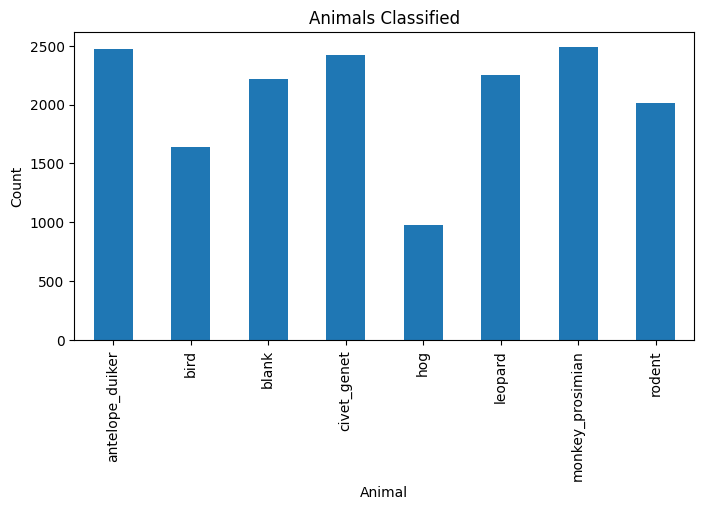

In [ ]:
# Plot the bar graph
plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Animals Classified')
plt.show()


In [ ]:
train_feature_df= pd.DataFrame(train_feature_data)

# Count the number of occurrences of each site
site_counts = train_feature_df['site'].value_counts()

top_site_count=site_counts.head(10);
# Print the site counts
print(top_site_count)

S0060    1132
S0009     664
S0063     557
S0008     541
S0036     456
S0043     444
S0059     438
S0038     429
S0120     423
S0062     380
Name: site, dtype: int64


Text(0.5, 1.0, 'Top Site Counts')

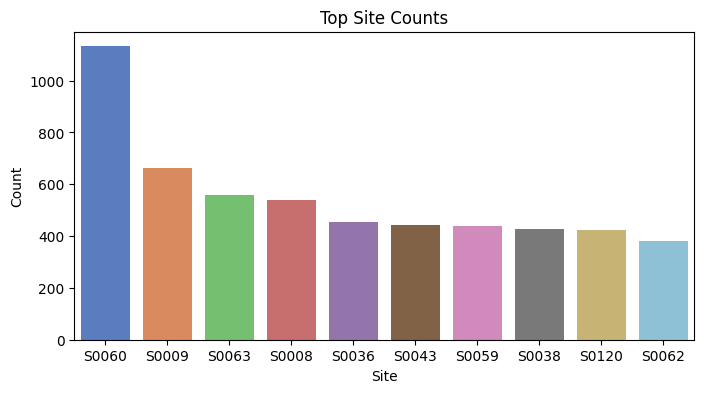

In [ ]:
# Plot the bar graph
plt.figure(figsize=(8, 4))
sns.barplot(x=top_site_count.index, y=top_site_count.values, palette='muted')
plt.xlabel('Site')
plt.ylabel('Count')
plt.title('Top Site Counts')

In [ ]:
# Creating a dictionary to map the labels to numbers
label_mapping = {
    'antelope_duiker': 1,
    'bird': 2,
    'blank': 3,
    'civet_genet': 4,
    'hog': 5,
    'leopard': 6,
    'monkey_prosimian': 7,
    'rodent': 8
}
print(label_mapping)


{'antelope_duiker': 1, 'bird': 2, 'blank': 3, 'civet_genet': 4, 'hog': 5, 'leopard': 6, 'monkey_prosimian': 7, 'rodent': 8}


In [ ]:
train_features_df = train_feature_data
train_labels_df = train_label_data
# Add the `id` column to the `train_feature_df` dataframe
train_features_df['id'] = train_features_df['id']
# Merge the features and labels dataframes based on the 'id' column
train_merged_df = pd.merge(train_labels_df, train_features_df, on='id')
train_merged_df.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,filepath,site
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train_features/ZJ000000.jpg,S0120
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,train_features/ZJ000001.jpg,S0069
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,train_features/ZJ000002.jpg,S0009
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,train_features/ZJ000003.jpg,S0008
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train_features/ZJ000004.jpg,S0036


In [ ]:
# Define the base path for the new organized structure
base_path = Path("/content/drive/MyDrive/MachineLearning")

In [ ]:

# Create a train directory for each label
labels = [col for col in train_labels_df.columns if col != 'id']  # Exclude the 'id' column by filtering
for label in labels:
    dir_path = base_path/"train_data"/ label
    dir_path.mkdir(parents=True, exist_ok=True)
labels
# Create a eval directory for each label
labels = [col for col in train_labels_df.columns if col != 'id']  # Exclude the 'id' column by filtering
for label in labels:
    dir_path = base_path/"eval_data"/ label
    dir_path.mkdir(parents=True, exist_ok=True)
labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [ ]:
def display_images_from_category(category_name):
    # Filter images from the category
    sample_images = train_merged_df[train_merged_df[category_name] == 1].sample(n=2)

    # Display the images
    plt.figure(figsize=(20, 20))

    # Loop through the 2 images and display them
    for i, image_row in enumerate(sample_images.itertuples(), 1):
        img_path = image_row.filepath
        img = mpimg.imread('/content/drive/MyDrive/MachineLearning/ProjectDataSet/'+img_path)  # Read in the image from filepath
        plt.subplot(2, 2, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# call the function for each category using the names from label_mapping
for category_name in label_mapping.keys():
    print(f"Displaying images for category: {category_name}")
    display_images_from_category(category_name)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# RUN ONLY ONCE
import pandas as pd
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split  # This helps in splitting the dataset

# Randomly shuffle the dataframe and split it (95% training, 5% evaluation)
train_data, eval_data = train_test_split(train_merged_df, test_size=0.05, shuffle=True)

# Define the directories for the organized datasets
train_directory = base_path / "train_data"
eval_directory = base_path / "eval_data"

# Make sure the destination directories exist
train_directory.mkdir(parents=True, exist_ok=True)
eval_directory.mkdir(parents=True, exist_ok=True)


def copy_images_to_label_dir(row, destination):
    for label in labels:
        if row[label] > 0:
            src = Path(row['filepath'])
            if not src.is_absolute():
                src = Path(base_path/"ProjectDataSet") / src

            # Ensure the label directory exists within the destination directory
            label_dir = destination / label
            label_dir.mkdir(parents=True, exist_ok=True)

            dest = label_dir / src.name  # The destination includes the label directory

            shutil.copy(src, dest)

# Apply the function to each row in the train and eval dataframes to copy the images to the correct directory
train_data.apply(lambda row: copy_images_to_label_dir(row, train_directory), axis=1)
eval_data.apply(lambda row: copy_images_to_label_dir(row, eval_directory), axis=1)

print(f"Train images copied successfully to {train_directory}.")
print(f"Evaluation images copied successfully to {eval_directory}.")


Train images copied successfully to /content/drive/MyDrive/MachineLearning/train_data.
Evaluation images copied successfully to /content/drive/MyDrive/MachineLearning/eval_data.


In [ ]:

def view_random_images(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)

    random_images = random.sample(os.listdir(target_folder), 9)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        img_path = os.path.join(target_folder, random_images[i])
        img = mpimg.imread(img_path)
        ax.imshow(img, aspect= "auto")
        ax.axis("off")

    plt.suptitle(target_class, fontsize=16)
    plt.tight_layout()
    plt.show()


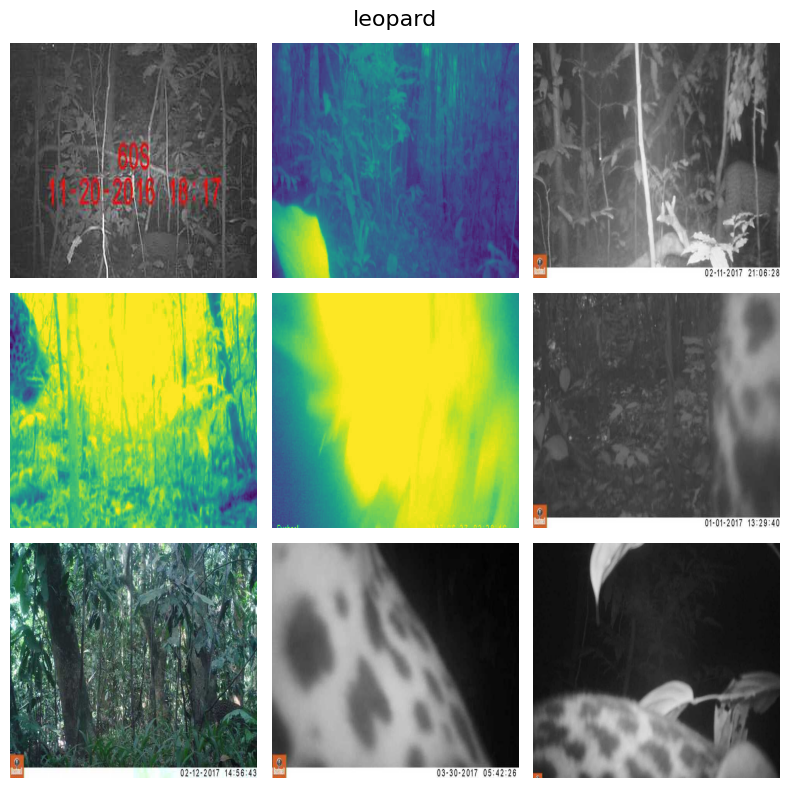

In [ ]:
view_random_images(base_path/"train_data", "leopard")


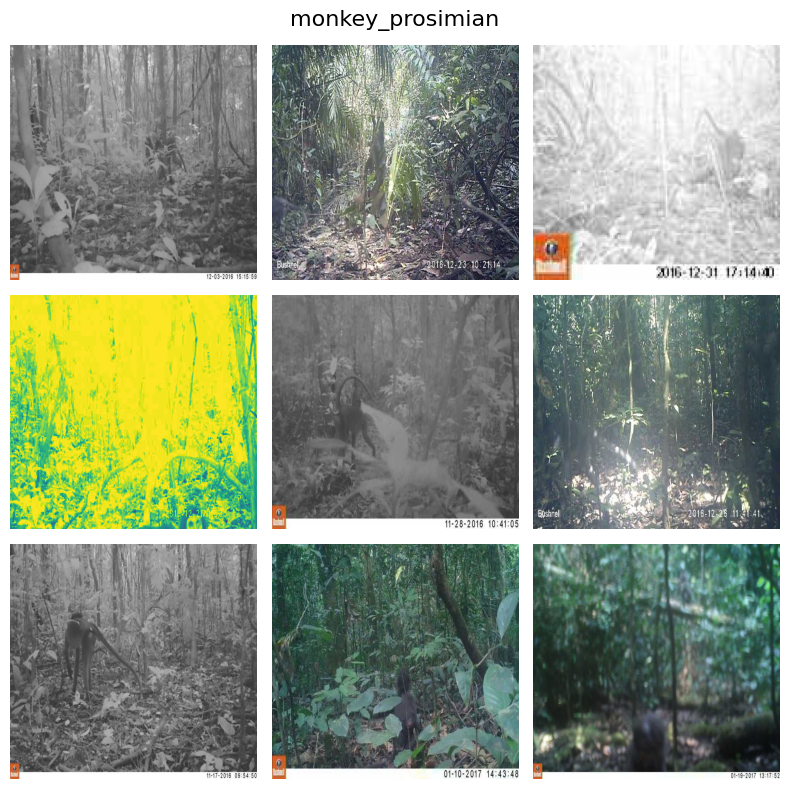

In [ ]:
view_random_images(base_path/"train_data", "monkey_prosimian")

In [ ]:
def create_barplot(target_dir,Title):
    class_counts = []
    class_names = []

    # Iterate over subdirectories
    for root, dirs, files in os.walk(target_dir):
        if len(files) > 0:
            class_counts.append(len(files))
            class_names.append(os.path.basename(root))



    # Plot the bar graph
    plt.bar(class_names, class_counts)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(Title + " Class Counts")
    plt.xticks(rotation=90)
    for i, count in enumerate(class_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

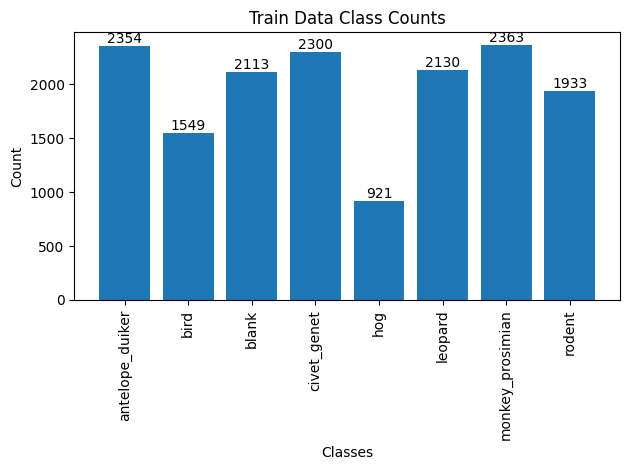

In [ ]:
create_barplot(base_path/"train_data","Train Data")



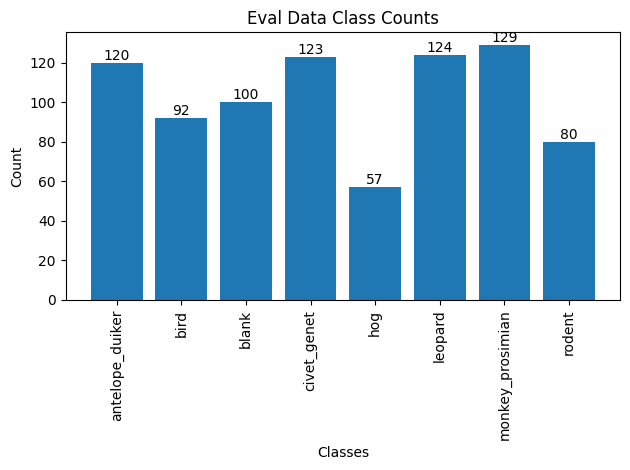

In [ ]:
create_barplot(base_path/"eval_data" ,"Eval Data")

# Baseline Model - ResNet **50**

In [ ]:
train_dir = base_path/'train_data'
validation_dir = base_path/'eval_data'

# Define image size and batch size
img_size = (224, 224)
batch_size = 100

# Data augmentation for training set
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Load and prepare the datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Print the number of classes and class labels
num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())
print("Number of classes:", num_classes)
print("Class labels:", class_labels)


Found 15663 images belonging to 8 classes.
Found 825 images belonging to 8 classes.
Number of classes: 8
Class labels: ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']


# ResNet 50 Model **Architecture**

In [ ]:
model = Sequential()

# First layer is the Resnet50 pretrained model
model.add(ResNet50(include_top = False, pooling = 'avg'))

# 2nd layer is a Dense layer for n-class classification, using SoftMax activation
model.add(Dense(8, activation = 'softmax'))

#Freeze the pretrained resnet50 layer
model.layers[0].trainable = False
#get the summary of the model
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 16392 (64.03 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# for learning rate decay
def learning_rate_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay after 5 epochs

In [ ]:
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model_new.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

# Train the model with learning rate decay, early stopping, and model checkpoint
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)

Epoch 1/10
157/157 [==============================] - 65s 386ms/step - loss: 1.2633 - accuracy: 0.5388 - val_loss: 1.0145 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 2/10
157/157 [==============================] - 61s 386ms/step - loss: 0.9300 - accuracy: 0.6618 - val_loss: 0.8855 - val_accuracy: 0.6873 - lr: 0.0010
Epoch 3/10
157/157 [==============================] - 60s 383ms/step - loss: 0.8210 - accuracy: 0.7096 - val_loss: 0.8018 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 4/10
157/157 [==============================] - 61s 385ms/step - loss: 0.7581 - accuracy: 0.7318 - val_loss: 0.7546 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 5/10
157/157 [==============================] - 61s 390ms/step - loss: 0.7071 - accuracy: 0.7515 - val_loss: 0.7300 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 6/10
157/157 [==============================] - 61s 387ms/step - loss: 0.6595 - accuracy: 0.7749 - val_loss: 0.7053 - val_accuracy: 0.7636 - lr: 9.0484e-04
Epoch 7/10
157/157 [============================

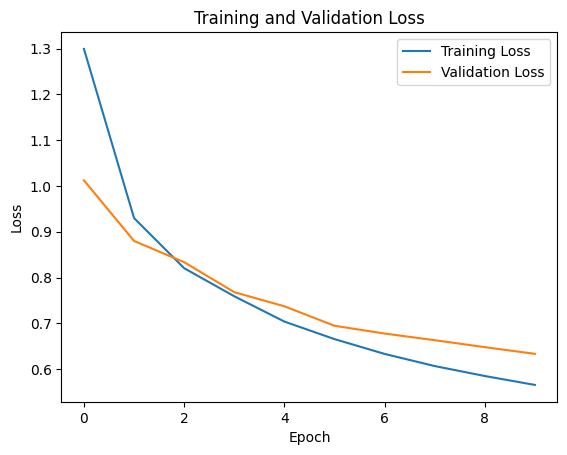

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


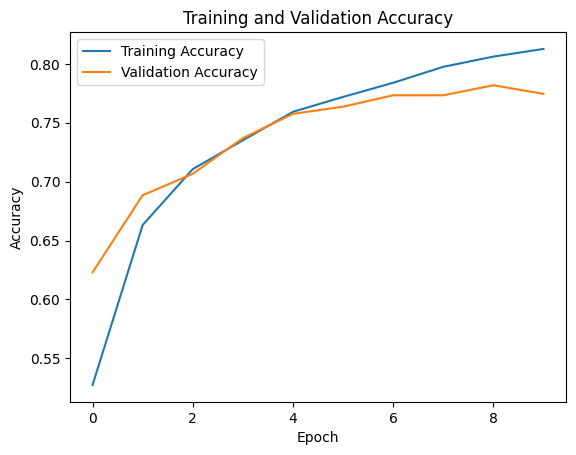

In [ ]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# ResNet50 - Model Prediction - Creating Submission **file**

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Assuming 'base_path' is defined and 'model', 'img_size', and 'batch_size' are previously defined
test_dir = base_path / "ProjectDataSet" / "test_features"
file_paths = [test_dir / fname for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
df_test = pd.DataFrame({'filename': [fp.name for fp in file_paths]})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_dir),
    x_col='filename',
    y_col=None,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Predict and Save
predictions = model.predict(test_generator)
image_ids = df_test['filename'].str.split('.').str[0]
df_predictions = pd.DataFrame(predictions, columns=class_labels)
df_predictions.insert(0, 'id', image_ids)

# Sort the DataFrame by 'id' in ascending order
df_predictions = df_predictions.sort_values(by='id')

# Set pandas option to display floats using decimal instead of scientific notation
pd.set_option('display.float_format', lambda x: '%.15f' % x)

# Save the sorted DataFrame to a CSV file with UTF-8 encoding and decimal format for floats
output_path = base_path / "submission_format.csv"
df_predictions.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')


Found 4464 validated image filenames.
140/140 [==============================] - 15s 109ms/step


# **ReseNet 152 Model Architecture and Approach**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Data augmentation for training set
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Load and prepare the datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)
# Model Architecture definition
model2 = Sequential()

model2.add(ResNet152(include_top=False, pooling='avg', weights='imagenet'))


model2.add(Dense(8, activation='softmax'))

model2.layers[0].trainable = False

model2.summary()

# Compile the model
model2.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model_new.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

# Train the model with early_stopping
resnet152_history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


Found 15663 images belonging to 8 classes.
Found 825 images belonging to 8 classes.
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_19 (Dense)            (None, 8)                 16392     
                                                                 
Total params: 58387336 (222.73 MB)
Trainable params: 16392 (64.03 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 79s 443ms/step - loss: 1.1927 - accuracy: 0.5627 - val_loss: 0.9670 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 2/10
157/157 [==============================] - 63s 399ms/step - loss: 0.8775 - accuracy: 0.6898 - val_loss: 0.8398 - val_accuracy: 0.6994 - lr: 0.0010
Ep

# ResNat152 Model **Predictions**
# Creating Submission **file**

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

test_dir = base_path / "ProjectDataSet" / "test_features"
file_paths = [test_dir / fname for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
df_test = pd.DataFrame({'filename': [fp.name for fp in file_paths]})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=str(test_dir),
    x_col='filename',
    y_col=None,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Predict using the ResNet152 model (model2)
predictions_ResNet152 = model2.predict(test_generator)
image_ids = df_test['filename'].str.split('.').str[0]
df_predictions_ResNet152 = pd.DataFrame(predictions_ResNet152, columns=class_labels)
df_predictions_ResNet152.insert(0, 'id', image_ids)

# Sort the DataFrame by 'id' in ascending order
df_predictions_ResNet152 = df_predictions_ResNet152.sort_values(by='id')

# Set pandas option to display floats using decimal instead of scientific notation
pd.set_option('display.float_format', lambda x: '%.15f' % x)

# Saving the sorted DataFrame to a CSV file with UTF-8 encoding and decimal format for floats
output_path = base_path / "submission_format_ResNet152.csv"
df_predictions_ResNet152.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')


Found 4464 validated image filenames.
45/45 [==============================] - 19s 358ms/step


# Ensemble Model( EfficientNet B0 + ResNet50)**bold text**


*   Model Architecture
*   Freezing layers
*   Adding Dropout Layers




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Enabling mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

train_dir = base_path/'train_data'
validation_dir = base_path/'eval_data'

# Defining image size and batch size
img_size = (224, 224)
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Loading and prepare datasets
train_generator = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
validation_generator = datagen.flow_from_directory(validation_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

# Define the base models
def create_base_model(model_name, img_size):
    input = Input(shape=img_size + (3,))
    if model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_tensor=input, weights='imagenet')
    else:
        base_model = ResNet50(include_top=False, input_tensor=input, weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

resnet_model = create_base_model('ResNet50', img_size)
efficientnet_model = create_base_model('EfficientNetB0', img_size)

# Unfreeze layers for fine-tuning
for layer in resnet_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

for layer in efficientnet_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Ensemble model
combined_input = concatenate([resnet_model.output, efficientnet_model.output])
combined_output = Dense(8, activation='softmax')(combined_input)
ensemble_model = Model(inputs=[resnet_model.input, efficientnet_model.input], outputs=combined_output)

# Ensemble model with Dropout for regularization
combined_input = concatenate([resnet_model.output, efficientnet_model.output])
x = Dropout(0.5)(combined_input)  # Add dropout with a rate of 50%
combined_output = Dense(8, activation='softmax')(x)
ensemble_model = Model(inputs=[resnet_model.input, efficientnet_model.input], outputs=combined_output)

# Compile the model
ensemble_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_ensemble_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

def pair_generator(base_generator):
    for batch_x, batch_y in base_generator:
        yield ([batch_x, batch_x], batch_y)

# Create paired generators for training and validation
paired_train_generator = pair_generator(train_generator)
paired_validation_generator = pair_generator(validation_generator)

# Train the model
history = ensemble_model.fit(
    paired_train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=paired_validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Found 15663 images belonging to 8 classes.
Found 825 images belonging to 8 classes.
16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/10
490/490 [==============================] - 7745s 16s/step - loss: 0.7287 - accuracy: 0.7462 - val_loss: 0.8348 - val_accuracy: 0.7248
Epoch 2/10
490/490 [==============================] - 157s 320ms/step - loss: 0.3093 - accuracy: 0.8956 - val_loss: 0.7909 - val_accuracy: 0.7345
Epoch 3/10
490/490 [==============================] - 158s 323ms/step - loss: 0.1832 - accuracy: 0.9378 - val_loss: 0.4527 - val_accuracy: 0.8558
Epoch 4/10
490/490 [==============================] - 158s 322ms/step - loss: 0.1440 - accuracy: 0.9537 - val_loss: 0.6394 - val_accuracy: 0.8242
Epoch 5/10
490/490 [==============================] - 159s 324ms/step - loss: 0.1084 - accuracy: 0.9640 - val_loss: 0.3708 - val_accuracy: 0.9006
Epoch 6/10
490/490 [==============================] - 158s 322ms/step - loss: 0.1052 - accuracy: 0.9658 - val_loss: 0.3993

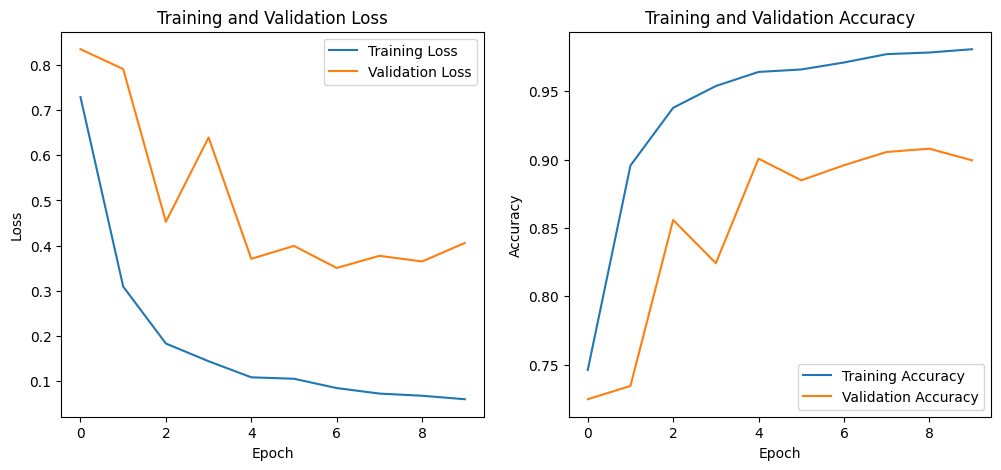

In [ ]:
import matplotlib.pyplot as plt

# Training and validation loss and accuracy data
train_loss = [0.7287, 0.3093, 0.1832, 0.1440, 0.1084, 0.1052, 0.0846, 0.0724, 0.0676, 0.0599]
train_accuracy = [0.7462, 0.8956, 0.9378, 0.9537, 0.9640, 0.9658, 0.9709, 0.9770, 0.9782, 0.9806]
val_loss = [0.8348, 0.7909, 0.4527, 0.6394, 0.3708, 0.3993, 0.3505, 0.3774, 0.3649, 0.4058]
val_accuracy = [0.7248, 0.7345, 0.8558, 0.8242, 0.9006, 0.8848, 0.8958, 0.9055, 0.9079, 0.8994]

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model_path = base_path /'my_ensemble_model.h5'  # Path in Google Drive
ensemble_model.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_path_keras = base_path /'my_ensemble_model.keras'  # Path in Google Drive
ensemble_model.save(model_path_keras)

# **Ensemble Model Predictions**
# Creating the submission **file**

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from pathlib import Path

#base path to the project dataset and model
test_dir = base_path / "ProjectDataSet" / "test_features"

img_size = (224, 224)

# Loading the model weights
ensemble_model.load_weights('best_ensemble_model.h5')

# Preparing the dataframe to save the predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Predict and collect results
total_images = len(os.listdir(test_dir))
processed_images = 0
for img_name in os.listdir(test_dir):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        img_path = test_dir / img_name
        img_array = preprocess_image(img_path, img_size)
        img_id = Path(img_name).stem

        predictions = ensemble_model.predict([img_array, img_array], verbose=0)
        predictions = predictions.flatten().tolist()  # Flatten the predictions

        # Prepare the data for this image
        img_results = [img_id] + predictions

        # Append to the dataframe
        results_df.loc[len(results_df)] = img_results

        # Update the processed images count and print the progress
        processed_images += 1
        print(f"Processed {processed_images}/{total_images} images.")

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Set pandas option to display floats using decimal instead of scientific notation
pd.set_option('display.float_format', lambda x: '%.15f' % x)

# Save predictions to CSV
output_path = base_path / "ensemble_model_predictions.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


Processed 1/4464 images.
Processed 2/4464 images.
Processed 3/4464 images.
Processed 4/4464 images.
Processed 5/4464 images.
Processed 6/4464 images.
Processed 7/4464 images.
Processed 8/4464 images.
Processed 9/4464 images.
Processed 10/4464 images.
Processed 11/4464 images.
Processed 12/4464 images.
Processed 13/4464 images.
Processed 14/4464 images.
Processed 15/4464 images.
Processed 16/4464 images.
Processed 17/4464 images.
Processed 18/4464 images.
Processed 19/4464 images.
Processed 20/4464 images.
Processed 21/4464 images.
Processed 22/4464 images.
Processed 23/4464 images.
Processed 24/4464 images.
Processed 25/4464 images.
Processed 26/4464 images.
Processed 27/4464 images.
Processed 28/4464 images.
Processed 29/4464 images.
Processed 30/4464 images.
Processed 31/4464 images.
Processed 32/4464 images.
Processed 33/4464 images.
Processed 34/4464 images.
Processed 35/4464 images.
Processed 36/4464 images.
Processed 37/4464 images.
Processed 38/4464 images.
Processed 39/4464 ima

# Ensemble Model with L1L2 **Regularization**

* Model Architecture
* PreProcessing Images
* creating base model
* UnFreezing layers for fine tuning
* L1L2 Regularization

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Enable mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

train_dir = base_path/'train_data'
validation_dir = base_path/'eval_data'

img_size = (224, 224)
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Load and prepare datasets
train_generator = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
validation_generator = datagen.flow_from_directory(validation_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')





Found 15663 images belonging to 8 classes.
Found 825 images belonging to 8 classes.


In [ ]:
# Define the base models
def create_base_model(model_name, img_size):
    input = Input(shape=img_size + (3,))
    if model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_tensor=input, weights='imagenet')
    else:
        base_model = ResNet50(include_top=False, input_tensor=input, weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

resnet_model = create_base_model('ResNet50', img_size)
efficientnet_model = create_base_model('EfficientNetB0', img_size)

# Unfreeze layers for fine-tuning
for layer in resnet_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

for layer in efficientnet_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Ensemble model
combined_input = concatenate([resnet_model.output, efficientnet_model.output])
combined_output = Dense(8, activation='softmax')(combined_input)  # number of classes
ensemble_model = Model(inputs=[resnet_model.input, efficientnet_model.input], outputs=combined_output)

# Ensemble model with Dropout for regularization
combined_input = concatenate([resnet_model.output, efficientnet_model.output])
x = Dropout(0.5)(combined_input)  #  dropout with a rate of 50%
combined_output = Dense(8, activation='softmax')(x)  # number of classes
ensemble_model_drop = Model(inputs=[resnet_model.input, efficientnet_model.input], outputs=combined_output)

# Compile the model
ensemble_model_drop.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
# New Arch with regularization
#  regularization parameters
l1_reg = 1e-5  # L1 regularization value
l2_reg = 1e-4  # L2 regularization value

# Defining the base models with regularization and dropout
def create_base_model(model_name, img_size, dropout_rate=0.5):
    input = Input(shape=img_size + (3,))
    if model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(include_top=False, input_tensor=input, weights='imagenet')
    else:
        base_model = ResNet50(include_top=False, input_tensor=input, weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)  # Add dropout
    return Model(inputs=base_model.input, outputs=x)

# Create base models
resnet_model = create_base_model('ResNet50', img_size)
efficientnet_model = create_base_model('EfficientNetB0', img_size)

# Combining the outputs of the two models
combined_input = concatenate([resnet_model.output, efficientnet_model.output])

# Adding L1 and L2 regularization to the Dense layer
ensemble_output = Dense(8, activation='softmax', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(combined_input)

# Now ensemble_model includes both dropout and regularization
ensemble_model = Model(inputs=[resnet_model.input, efficientnet_model.input], outputs=ensemble_output)

# Compile the model
ensemble_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 2s 0us/step


Ensemble Model Training

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_ensemble_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

def pair_generator(base_generator):
    for batch_x, batch_y in base_generator:
        yield ([batch_x, batch_x], batch_y)

# Create paired generators for training and validation
paired_train_generator = pair_generator(train_generator)
paired_validation_generator = pair_generator(validation_generator)

# Train the model
history_drop = ensemble_model.fit(
    paired_train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=paired_validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
490/490 [==============================] - 13724s 28s/step - loss: 0.8856 - accuracy: 0.6925 - val_loss: 0.6563 - val_accuracy: 0.7721
Epoch 2/10
490/490 [==============================] - 71s 145ms/step - loss: 0.3991 - accuracy: 0.8671 - val_loss: 0.3972 - val_accuracy: 0.8594
Epoch 3/10
490/490 [==============================] - 70s 142ms/step - loss: 0.2582 - accuracy: 0.9147 - val_loss: 0.5191 - val_accuracy: 0.7976
Epoch 4/10
490/490 [==============================] - 70s 142ms/step - loss: 0.1817 - accuracy: 0.9423 - val_loss: 0.7124 - val_accuracy: 0.7842
Epoch 5/10
490/490 [==============================] - 70s 143ms/step - loss: 0.1513 - accuracy: 0.9491 - val_loss: 0.4028 - val_accuracy: 0.8909


In [ ]:
import json
# Convert the history.history dict to a JSON file
with open('ensemble_model_history.json', 'w') as f:
    json.dump(history_drop.history, f)


In [ ]:
from google.colab import files

files.download('ensemble_model_history.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_path = base_path /'my_ensemble_model_drop_l1l2.keras'  # Path in Google Drive
ensemble_model.save(model_path)

In [ ]:
model_path = base_path /'my_ensemble_model_drop_l1l2.h5'  # Path in Google Drive
ensemble_model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


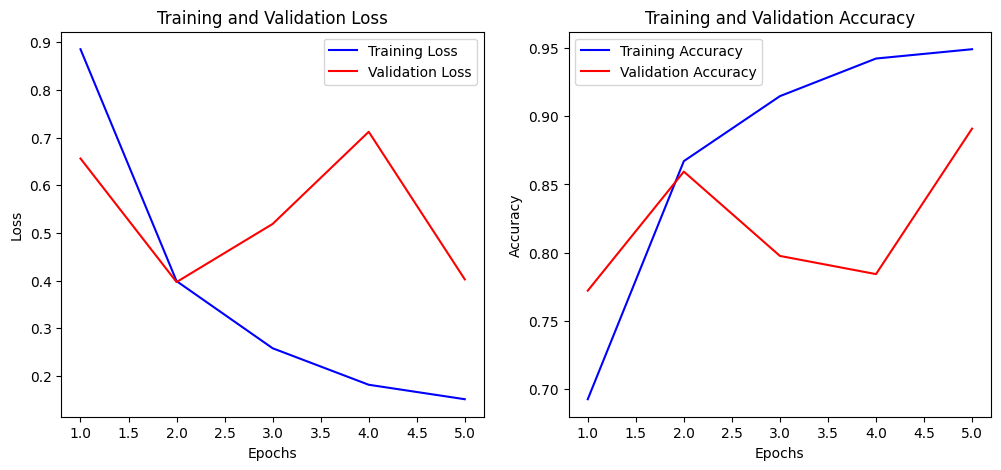

In [ ]:
import matplotlib.pyplot as plt

# Extracting the data
training_loss = history_drop.history['loss']
validation_loss = history_drop.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting the Loss Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# If accuracy is available
if 'accuracy' in history_drop.history:
    training_accuracy = history_drop.history['accuracy']
    validation_accuracy = history_drop.history['val_accuracy']

    # Plotting the Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()


Ensemeble Model Predictions
Creating Submission file

In [ ]:
from tqdm import tqdm

# Load the model weights
ensemble_model.load_weights('best_ensemble_model.h5')

# Prepare the dataframe to save the predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Get all image filenames
image_filenames = [img_name for img_name in os.listdir(test_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in tqdm(image_filenames, desc='Predicting', unit='image'):
    img_path = test_dir / img_name
    img_array = preprocess_image(img_path, img_size)
    img_id = Path(img_name).stem  # Remove file extension from img_name

    predictions = ensemble_model.predict([img_array, img_array], verbose=0)
    predictions = predictions.flatten().tolist()  # Flatten the predictions

    img_results = [img_id] + predictions
    results_df.loc[len(results_df)] = img_results

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Save predictions to CSV
output_path = base_path / "ensemble_model_predictions_l1l2.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


NameError: ignored

# EfficeiNet B4 **Model**
* Image Preprocessing
* Creating base models
* Defining Callbacks, EarlyStoppong
* Defining Model Checkpoints
* Model Training

In [ ]:
# Training data augmentation and preprocessing for EfficientNetB4
train_datagen_b4 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]
)

# Validation data preprocessing for EfficientNetB4
val_datagen_b4 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Create training and validation data generators for EfficientNetB4
train_generator_b4 = train_datagen_b4.flow_from_directory(
    train_dir,
    target_size=(384, 384),
    batch_size=32,
    class_mode='sparse'
)



Found 15663 images belonging to 8 classes.


In [ ]:
val_generator_b4 = val_datagen_b4.flow_from_directory(
    validation_dir,
    target_size=(384, 384),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 825 images belonging to 8 classes.


In [ ]:
# Function to create a model with EfficientNet as a base
def create_model(base_model_func):
    input_tensor = Input(shape=img_size + (3,))
    base_model = base_model_func(include_top=False, input_tensor=input_tensor, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(8, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

# Create two models
model_b4 = create_model(EfficientNetB4)

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_b4 = ModelCheckpoint('best_model_b4.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')


In [ ]:

# Train each model separately
history_b4 = model_b4.fit(
    train_generator_b4,
    steps_per_epoch=len(train_generator_b4),
    epochs=10,
    validation_data=val_generator_b4,
    validation_steps=len(val_generator_b4),
    callbacks=[early_stopping, model_checkpoint_b4]
)


Epoch 1/10
490/490 [==============================] - 1176s 2s/step - loss: 0.7302 - accuracy: 0.7449 - val_loss: 0.5978 - val_accuracy: 0.8133
Epoch 2/10
490/490 [==============================] - 538s 1s/step - loss: 0.6220 - accuracy: 0.7788 - val_loss: 0.4822 - val_accuracy: 0.8412
Epoch 3/10
490/490 [==============================] - 536s 1s/step - loss: 0.5483 - accuracy: 0.8034 - val_loss: 0.4641 - val_accuracy: 0.8315
Epoch 4/10
490/490 [==============================] - 537s 1s/step - loss: 0.5062 - accuracy: 0.8207 - val_loss: 0.4442 - val_accuracy: 0.8364
Epoch 5/10
490/490 [==============================] - 538s 1s/step - loss: 0.4662 - accuracy: 0.8327 - val_loss: 0.3490 - val_accuracy: 0.8909
Epoch 6/10
490/490 [==============================] - 536s 1s/step - loss: 0.4475 - accuracy: 0.8389 - val_loss: 0.4466 - val_accuracy: 0.8376
Epoch 7/10
490/490 [==============================] - 536s 1s/step - loss: 0.4160 - accuracy: 0.8512 - val_loss: 0.4128 - val_accuracy: 0.849

In [ ]:
# Train each model separately
history_b4_new = model_b4.fit(
    train_generator_b4,
    steps_per_epoch=len(train_generator_b4),
    epochs=10,
    validation_data=val_generator_b4,
    validation_steps=len(val_generator_b4),
    callbacks=[early_stopping, model_checkpoint_b4]
)


In [ ]:
model_path = base_path /'model_b4.keras'  # Path in Google Drive
model_b4.save(model_path)
model_path = base_path /'model_b4.h5'  # Path in Google Drive
model_b4.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Convert the history.history dict to a JSON file
with open('model_b4.json', 'w') as f:
    json.dump(history_b4.history, f)
from google.colab import files

files.download('model_b4.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EfficientNet** B4 Predictions
Creating File Submission

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from pathlib import Path


test_dir = base_path / "ProjectDataSet" / "test_features"

# Load the model weights for both models
model_b4.load_weights('best_model_b4.h5')

# Prepare the dataframe to save the ensemble predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Get all image filenames
image_filenames = [img_name for img_name in os.listdir(test_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Predict and collect results using tqdm for progress bar
for img_name in tqdm(image_filenames, desc='Predicting', unit='image'):
    img_path = test_dir / img_name
    img_array = preprocess_image(img_path, img_size)
    img_id = Path(img_name).stem  #To Remove file extension from img_name

    # Predict with both models
    predictions_b4 = model_b4.predict(img_array, verbose=0)
    predictions_b4 = predictions_b4.flatten().tolist()
    img_results = [img_id] + predictions_b4
    results_df.loc[len(results_df)] = img_results

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Save predictions to CSV
output_path = base_path / "model_b4_predictions.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


Predicting: 100%|██████████| 4464/4464 [1:11:51<00:00,  1.04image/s]

All predictions have been saved to CSV.


EfficientNet B4 F1 Score

In [ ]:
from tensorflow.keras.models import load_model
from pathlib import Path

from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the model
model_path = base_path / 'model_b4.h5'
model = load_model(model_path)



val_datagen_b4 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_generator_b4 = val_datagen_b4.flow_from_directory(
    validation_dir,
    target_size=(384, 384),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)



# Predict on the validation data
predictions = model.predict(val_generator_b4, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = val_generator_b4.classes


f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")





Found 825 images belonging to 8 classes.
26/26 [==============================] - 645s 25s/step
F1 Score: 0.8900581904799473


# EfficeiNet V2s **Model**
* Image Preprocessing
* Creating base models
* Defining Callbacks, EarlyStoppong
* Defining Model Checkpoints
* Model Training

In [ ]:

train_dir = base_path/'train_data'
validation_dir = base_path/'eval_data'
# Define image size and batch size
img_size = (366, 366)
batch_size = 32

# Data augmentation for training set
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# Training data augmentation and preprocessing for EfficientNetV2S
train_datagen_v2s = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]
)



# Create training and validation data generators for EfficientNetV2S
train_generator_v2s = train_datagen_v2s.flow_from_directory(
    train_dir,
    target_size=(366, 366),
    batch_size=32,
    class_mode='sparse'
)




Found 15663 images belonging to 8 classes.
Found 825 images belonging to 8 classes.


In [ ]:
# Validation data preprocessing for EfficientNetV2S
val_datagen_v2s = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)
val_generator_v2s = val_datagen_v2s.flow_from_directory(
    validation_dir,
    target_size=(366, 366),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 825 images belonging to 8 classes.


In [ ]:
model_checkpoint_v2s = ModelCheckpoint('best_model_v2s.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')


In [ ]:
model_v2s = create_model(EfficientNetV2S)

82420632/82420632 [==============================] - 5s 0us/step


In [ ]:
history_v2s = model_v2s.fit(
    train_generator_v2s,
    steps_per_epoch=len(train_generator_v2s),
    epochs=10,
    validation_data=val_generator_v2s,
    validation_steps=len(val_generator_v2s),
    callbacks=[early_stopping, model_checkpoint_v2s]
)



Epoch 1/10
490/490 [==============================] - 543s 1s/step - loss: 1.0459 - accuracy: 0.6268 - val_loss: 0.7793 - val_accuracy: 0.7333
Epoch 2/10
490/490 [==============================] - 536s 1s/step - loss: 0.8315 - accuracy: 0.7051 - val_loss: 0.6617 - val_accuracy: 0.7648
Epoch 3/10
490/490 [==============================] - 535s 1s/step - loss: 0.7255 - accuracy: 0.7415 - val_loss: 0.5356 - val_accuracy: 0.8145
Epoch 4/10
490/490 [==============================] - 537s 1s/step - loss: 0.6529 - accuracy: 0.7688 - val_loss: 0.4869 - val_accuracy: 0.8267
Epoch 5/10
490/490 [==============================] - 536s 1s/step - loss: 0.5921 - accuracy: 0.7875 - val_loss: 0.4774 - val_accuracy: 0.8570
Epoch 6/10
490/490 [==============================] - 535s 1s/step - loss: 0.5579 - accuracy: 0.8038 - val_loss: 0.5360 - val_accuracy: 0.8303
Epoch 7/10
490/490 [==============================] - 537s 1s/step - loss: 0.5286 - accuracy: 0.8106 - val_loss: 0.3786 - val_accuracy: 0.8764

In [ ]:
model_path = base_path /'model_v2s.keras'  # Path in Google Drive
model_v2s.save(model_path)
model_path = base_path /'model_v2s.h5'  # Path in Google Drive
model_v2s.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Convert the history.history dict to a JSON file
with open('model_v2s.json', 'w') as f:
    json.dump(history_v2s.history, f)
from google.colab import files

files.download('model_v2s.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EfficientNet V2s **Predictions**
Creating a submission file

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from pathlib import Path


test_dir = base_path / "ProjectDataSet" / "test_features"

model_v2s.load_weights('best_model_v2s.h5')

# Prepare the dataframe to save the ensemble predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Get all image filenames
image_filenames = [img_name for img_name in os.listdir(test_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Predict and collect results using tqdm for progress bar
for img_name in tqdm(image_filenames, desc='Predicting', unit='image'):
    img_path = test_dir / img_name
    img_array = preprocess_image(img_path, img_size)
    img_id = Path(img_name).stem

    # Predict with both models
    predictions_v2s = model_v2s.predict(img_array, verbose=0)

    # Average the predictions
    predictions_v2s = predictions_v2s.flatten().tolist()  # Flatten the predictions

    img_results = [img_id] + predictions_v2s
    results_df.loc[len(results_df)] = img_results

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Save predictions to CSV
output_path = base_path / "model_v2s_predictions.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


Predicting: 100%|██████████| 4464/4464 [05:48<00:00, 12.81image/s]

All predictions have been saved to CSV.


EfficientNet V2s F1-Score

In [ ]:
from tensorflow.keras.models import load_model
from pathlib import Path

from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the model
model_path = base_path / 'model_v2s.h5'
model = load_model(model_path)


# Predict on the validation data
predictions = model.predict(val_generator_v2s, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = val_generator_v2s.classes


f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score V2s: {f1}")





26/26 [==============================] - 14s 372ms/step
F1 Score V2s: 0.8805483796373097


In [ ]:
import pandas as pd

model_b4_file_path = base_path / "model_b4_predictions.csv"
model_v2s_file_path = base_path / "model_v2s_predictions.csv"

# Load the CSV files
b4_df = pd.read_csv(model_b4_file_path)
v2s_df = pd.read_csv(model_v2s_file_path)

# Check if IDs match and are in the same order
if not b4_df['id'].equals(v2s_df['id']):
    raise ValueError("IDs do not match or are not in the same order")

# Average the predictions
average_predictions = (b4_df.iloc[:, 1:] + v2s_df.iloc[:, 1:]) / 2

# Create a new DataFrame with IDs and averaged predictions
averaged_df = pd.concat([b4_df[['id']], average_predictions], axis=1)

# Save the new DataFrame to a CSV file
output_csv_path = base_path / "Final_Submission_b4_v2s.csv"
averaged_df.to_csv(output_csv_path, index=False)

print("Averaged predictions saved to CSV.")


Averaged predictions saved to CSV.


In [ ]:
average_predictions

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.066239,0.000713,0.450697,0.014898,3.329127e-05,0.444545,0.005340,0.017533
1,0.694446,0.030694,0.041602,0.004915,4.163705e-02,0.000014,0.160164,0.026528
2,0.496258,0.000284,0.007587,0.419454,1.334813e-02,0.000010,0.009079,0.053980
3,0.000027,0.000359,0.000354,0.000137,6.908101e-06,0.999018,0.000066,0.000032
4,0.035718,0.005319,0.019030,0.000246,1.535833e-03,0.000065,0.931630,0.006457
...,...,...,...,...,...,...,...,...
4459,0.209436,0.036307,0.511937,0.000003,1.257059e-03,0.001094,0.093278,0.146688
4460,0.357177,0.034631,0.314422,0.000714,3.190109e-03,0.001978,0.282456,0.005433
4461,0.106706,0.000308,0.354544,0.062712,4.012698e-01,0.031162,0.003312,0.039986
4462,0.378303,0.020622,0.016871,0.000028,3.980328e-02,0.000021,0.538004,0.006347


# Ensemble (EfficientNet B4 + EfficientNet V2s) **Predictions**

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from pathlib import Path


test_dir = base_path / "ProjectDataSet" / "test_features"

# Load the model weights for both models
model_b4.load_weights('best_model_b4.h5')
model_v2s.load_weights('best_model_v2s.h5')

# Prepare the dataframe to save the ensemble predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Get all image filenames
image_filenames = [img_name for img_name in os.listdir(test_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Predict and collect results using tqdm for progress bar
for img_name in tqdm(image_filenames, desc='Predicting', unit='image'):
    img_path = test_dir / img_name
    img_array = preprocess_image(img_path, img_size)
    img_id = Path(img_name).stem  # Remove file extension from img_name

    # Predict with both models
    predictions_b4 = model_b4.predict(img_array, verbose=0)
    predictions_v2s = model_v2s.predict(img_array, verbose=0)

    # Average the predictions
    predictions_ensemble = (predictions_b4 + predictions_v2s) / 2
    predictions_ensemble = predictions_ensemble.flatten().tolist()  # Flatten the predictions

    img_results = [img_id] + predictions_ensemble
    results_df.loc[len(results_df)] = img_results

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Save predictions to CSV
output_path = base_path / "Final_Submission_Model.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


Predicting: 100%|██████████| 4464/4464 [10:56<00:00,  6.80image/s]


All predictions have been saved to CSV.


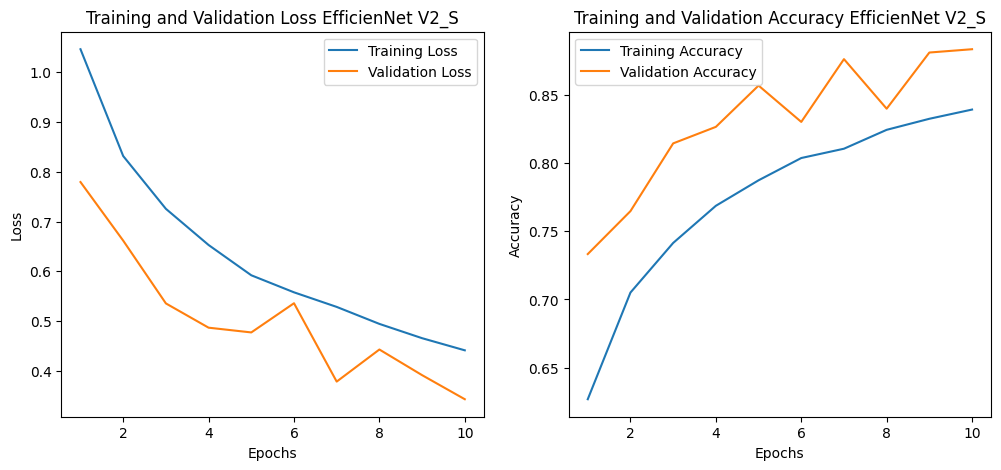

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values for both training and validation from the history object
train_loss = history_v2s.history['loss']
val_loss = history_v2s.history['val_loss']
train_accuracy = history_v2s.history['accuracy']
val_accuracy = history_v2s.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss EfficienNet V2_S')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy EfficienNet V2_S')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# ROC Curve for EfficientNet **V2s**

1/1 [==============================] - 0s 50ms/step


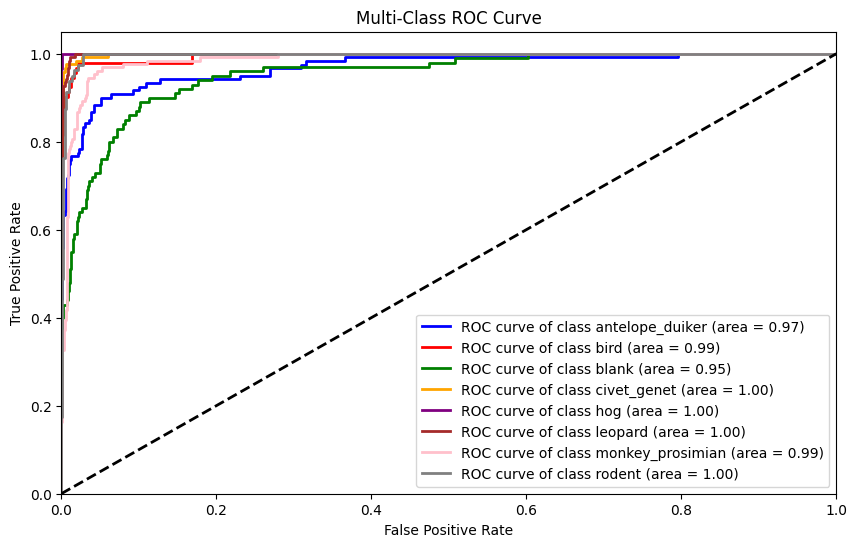

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize the prediction array and true labels array
predictions = []
true_labels = []

# Iterate over the generator
for i in range(len(val_generator_v2s)):
    x, y = val_generator_v2s[i]
    pred = model_v2s.predict(x)
    predictions.extend(pred)
    true_labels.extend(y)

    if i == (val_generator_v2s.n // val_generator_v2s.batch_size):
        break

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Binarize the true labels
n_classes = 8
true_labels = label_binarize(true_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']  # Class names

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


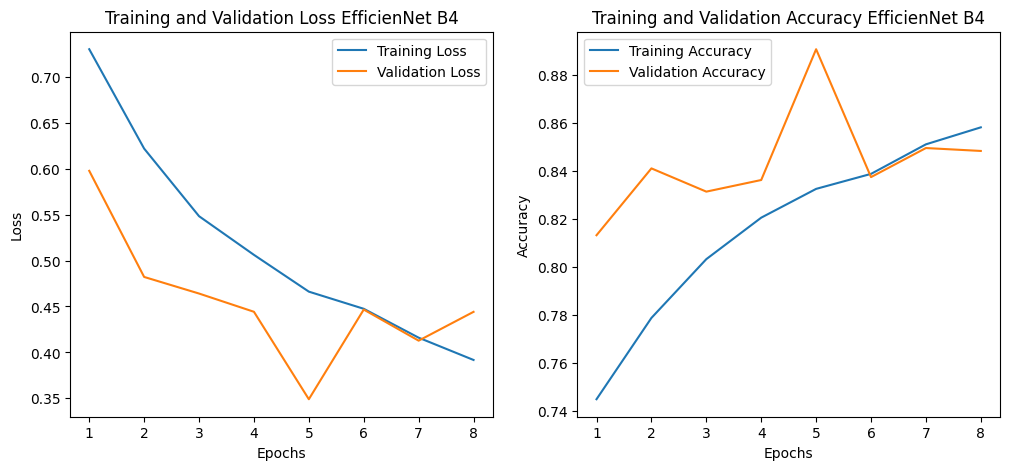

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values for both training and validation from the history object
train_loss = history_b4.history['loss']
val_loss = history_b4.history['val_loss']
train_accuracy = history_b4.history['accuracy']
val_accuracy = history_b4.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss EfficienNet B4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy EfficienNet B4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# ROC Curve for EfficientNet **B4**

1/1 [==============================] - 0s 51ms/step


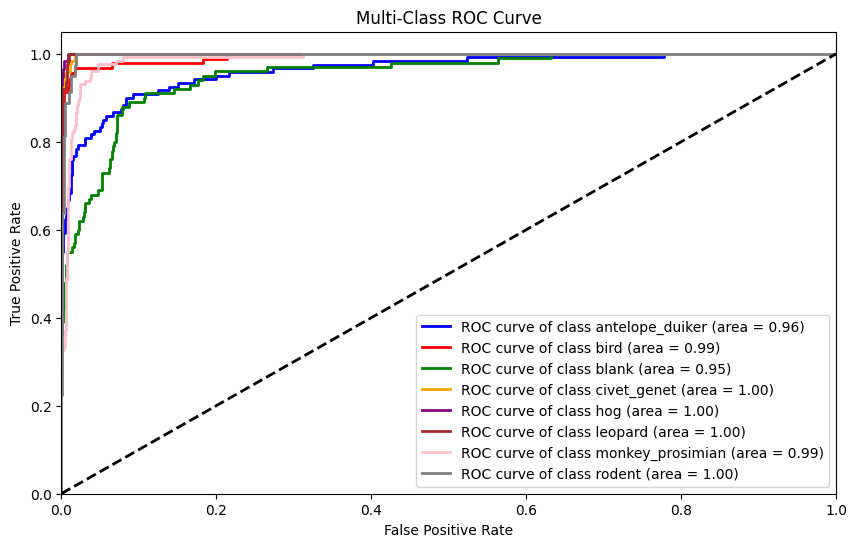

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize the prediction array and true labels array
predictions = []
true_labels = []

# Iterate over the generator
for i in range(len(val_generator_b4)):
    x, y = val_generator_b4[i]
    pred = model_v2s.predict(x)
    predictions.extend(pred)
    true_labels.extend(y)

    if i == (val_generator_b4.n // val_generator_b4.batch_size):
        break

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Binarize the true labels
n_classes = 8
true_labels = label_binarize(true_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']  # Class names

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Applying L1L2 Regularization on EfficientNet **B4**

In [ ]:
def create_model_2(base_model_func, l1=1e-5, l2=1e-4):
    input_tensor = Input(shape=(384, 384, 3))
    base_model = base_model_func(include_top=False, input_tensor=input_tensor, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(8, activation='softmax', kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model_b4_l1l2 = create_model_2(EfficientNetB4)


71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
history_b4_l1l2 = model_b4_l1l2.fit(
    train_generator_b4,
    steps_per_epoch=len(train_generator_b4),
    epochs=20,  # Increased epochs
    validation_data=val_generator_b4,
    validation_steps=len(val_generator_b4),
    callbacks=[early_stopping, model_checkpoint_b4]
)


Epoch 1/20
490/490 [==============================] - 7431s 15s/step - loss: 1.0781 - accuracy: 0.6202 - val_loss: 0.8952 - val_accuracy: 0.6933
Epoch 2/20
490/490 [==============================] - 614s 1s/step - loss: 0.7419 - accuracy: 0.7409 - val_loss: 0.5301 - val_accuracy: 0.8158
Epoch 3/20
490/490 [==============================] - 614s 1s/step - loss: 0.6229 - accuracy: 0.7815 - val_loss: 0.4482 - val_accuracy: 0.8521
Epoch 4/20
490/490 [==============================] - 614s 1s/step - loss: 0.5627 - accuracy: 0.7996 - val_loss: 0.4155 - val_accuracy: 0.8497
Epoch 5/20
490/490 [==============================] - 612s 1s/step - loss: 0.5069 - accuracy: 0.8200 - val_loss: 0.4686 - val_accuracy: 0.8412
Epoch 6/20
490/490 [==============================] - 611s 1s/step - loss: 0.4784 - accuracy: 0.8299 - val_loss: 0.4278 - val_accuracy: 0.8448
Epoch 7/20
490/490 [==============================] - 615s 1s/step - loss: 0.4402 - accuracy: 0.8477 - val_loss: 0.4321 - val_accuracy: 0.85

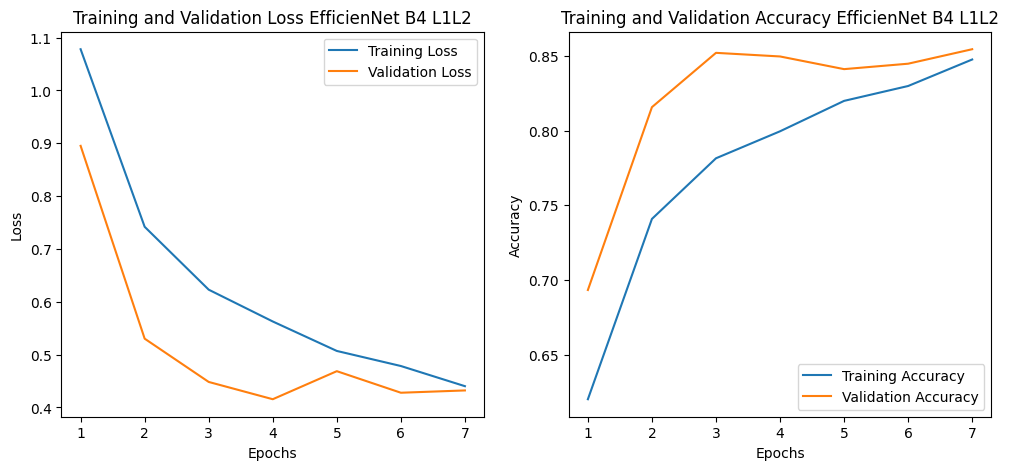

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values for both training and validation from the history object
train_loss = history_b4_l1l2.history['loss']
val_loss = history_b4_l1l2.history['val_loss']
train_accuracy = history_b4_l1l2.history['accuracy']
val_accuracy = history_b4_l1l2.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss EfficienNet B4 L1L2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy EfficienNet B4 L1L2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model_path = base_path /'model_b4_l1l2.keras'  # Path in Google Drive
model_b4_l1l2.save(model_path)
model_path = base_path /'model_b4_l1l2.h5'  # Path in Google Drive
model_b4_l1l2.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_b4_l1l2_E20 = create_model_2(EfficientNetB4)


In [ ]:
history_b4_l1l2_E20 = model_b4_l1l2_E20.fit(
    train_generator_b4,
    steps_per_epoch=len(train_generator_b4),
    epochs=20,  # Increased epochs
    validation_data=val_generator_b4,
    validation_steps=len(val_generator_b4)
)


Epoch 1/20
490/490 [==============================] - 612s 1s/step - loss: 0.5204 - accuracy: 0.8175 - val_loss: 0.4083 - val_accuracy: 0.8606
Epoch 2/20
490/490 [==============================] - 616s 1s/step - loss: 0.4754 - accuracy: 0.8302 - val_loss: 0.4166 - val_accuracy: 0.8558
Epoch 3/20
490/490 [==============================] - 613s 1s/step - loss: 0.4495 - accuracy: 0.8431 - val_loss: 0.4635 - val_accuracy: 0.8388
Epoch 4/20
490/490 [==============================] - 614s 1s/step - loss: 0.4292 - accuracy: 0.8489 - val_loss: 0.4133 - val_accuracy: 0.8594
Epoch 5/20
490/490 [==============================] - 614s 1s/step - loss: 0.4039 - accuracy: 0.8557 - val_loss: 0.3859 - val_accuracy: 0.8800
Epoch 6/20
490/490 [==============================] - 613s 1s/step - loss: 0.3806 - accuracy: 0.8622 - val_loss: 0.4769 - val_accuracy: 0.8582
Epoch 7/20
490/490 [==============================] - 615s 1s/step - loss: 0.3716 - accuracy: 0.8691 - val_loss: 0.3649 - val_accuracy: 0.8764

<function matplotlib.pyplot.show(close=None, block=None)>

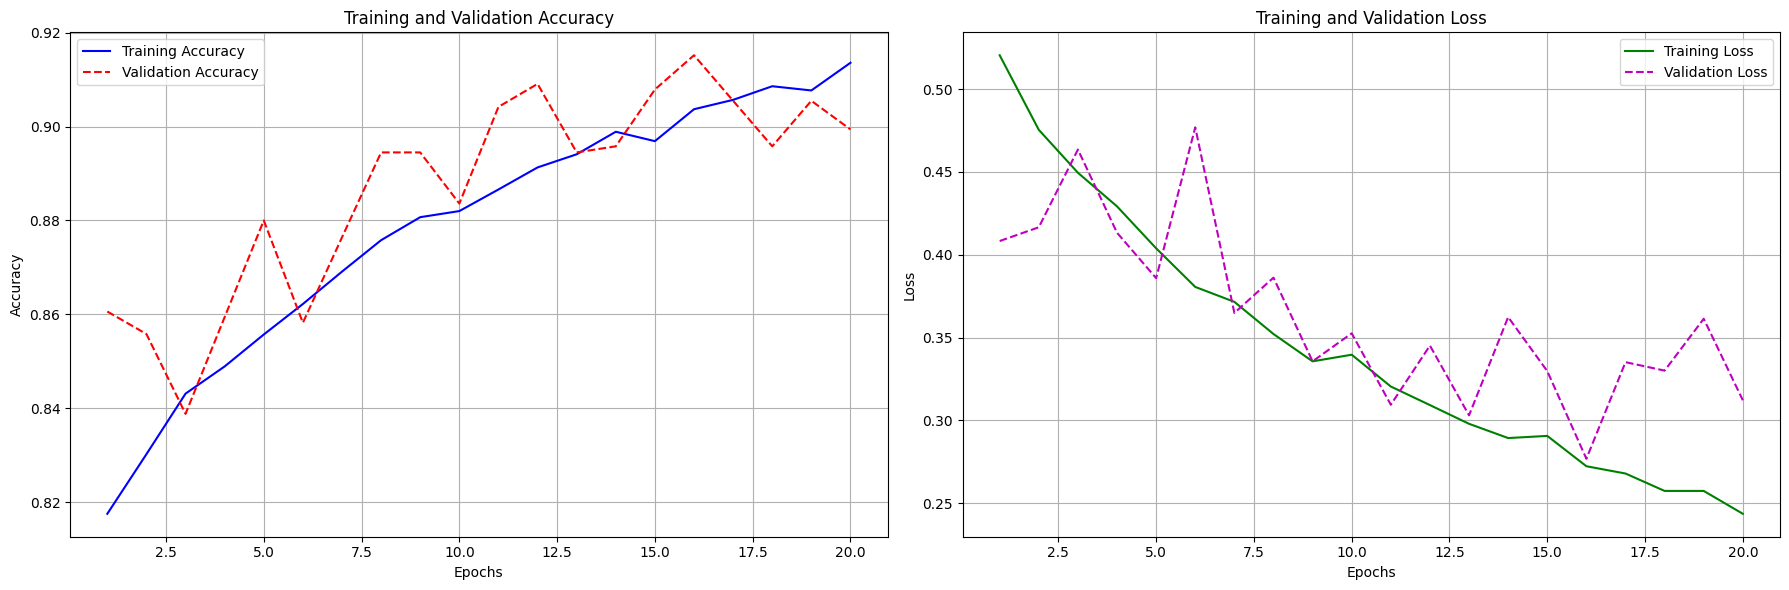

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 21))
train_loss = [
    0.5204, 0.4754, 0.4495, 0.4292, 0.4039, 0.3806, 0.3716, 0.3522, 0.3357,
    0.3397, 0.3205, 0.3093, 0.2980, 0.2894, 0.2907, 0.2724, 0.2680, 0.2575,
    0.2575, 0.2437
]
train_accuracy = [
    0.8175, 0.8302, 0.8431, 0.8489, 0.8557, 0.8622, 0.8691, 0.8758, 0.8807,
    0.8820, 0.8866, 0.8913, 0.8941, 0.8989, 0.8969, 0.9037, 0.9057, 0.9086,
    0.9077, 0.9136
]
val_loss = [
    0.4083, 0.4166, 0.4635, 0.4133, 0.3859, 0.4769, 0.3649, 0.3862, 0.3357,
    0.3526, 0.3095, 0.3452, 0.3031, 0.3624, 0.3298, 0.2769, 0.3352, 0.3301,
    0.3614, 0.3122
]
val_accuracy = [
    0.8606, 0.8558, 0.8388, 0.8594, 0.8800, 0.8582, 0.8764, 0.8945, 0.8945,
    0.8836, 0.9042, 0.9091, 0.8945, 0.8958, 0.9079, 0.9152, 0.9055, 0.8958,
    0.9055, 0.8994
]


# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation accuracy on the first subplot
ax1.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training and validation loss on the second subplot
ax2.plot(epochs, train_loss, 'g-', label='Training Loss')
ax2.plot(epochs, val_loss, 'm--', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show


# EfficientNet B4 **L1L2** Regularizarion Predictions

Creating submission file

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from pathlib import Path
import os
from tensorflow.keras.models import load_model

test_dir = base_path / "ProjectDataSet" / "test_features"


model_path = base_path / 'model_b4_l1l2.h5'
model = load_model(model_path)

# Prepare the dataframe to save the predictions
columns = ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
results_df = pd.DataFrame(columns=columns)

# Function to preprocess the image
def preprocess_image(img_path, img_size=(384, 384)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Get all image filenames
image_filenames = [img_name for img_name in os.listdir(test_dir) if img_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Predict and collect results using tqdm for progress bar
for img_name in tqdm(image_filenames, desc='Predicting', unit='image'):
    img_path = test_dir / img_name
    img_array = preprocess_image(img_path)
    img_id = Path(img_name).stem

    # Predict with the model
    predictions = model.predict(img_array, verbose=0)
    predictions = predictions.flatten().tolist()
    img_results = [img_id] + predictions
    results_df.loc[len(results_df)] = img_results

# Sort the DataFrame by 'id'
results_df = results_df.sort_values(by='id')

# Save predictions to CSV
output_path = base_path / "model_b4_l1l2_Submission.csv"
results_df.to_csv(str(output_path), index=False, encoding='utf-8', float_format='%.15f')

print("All predictions have been saved to CSV.")


Predicting: 100%|██████████| 4464/4464 [05:53<00:00, 12.62image/s]

All predictions have been saved to CSV.


In [ ]:
from tensorflow.keras.models import load_model
from pathlib import Path

from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the model
model_path = base_path / 'model_b4_l1l2_New.h5'
model = load_model(model_path)


# Predict on the validation data
predictions = model.predict(val_generator_b4, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = val_generator_b4.classes


f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score V2s: {f1}")





26/26 [==============================] - 13s 413ms/step
F1 Score V2s: 0.9070780289142253


26/26 [==============================] - 4s 150ms/step


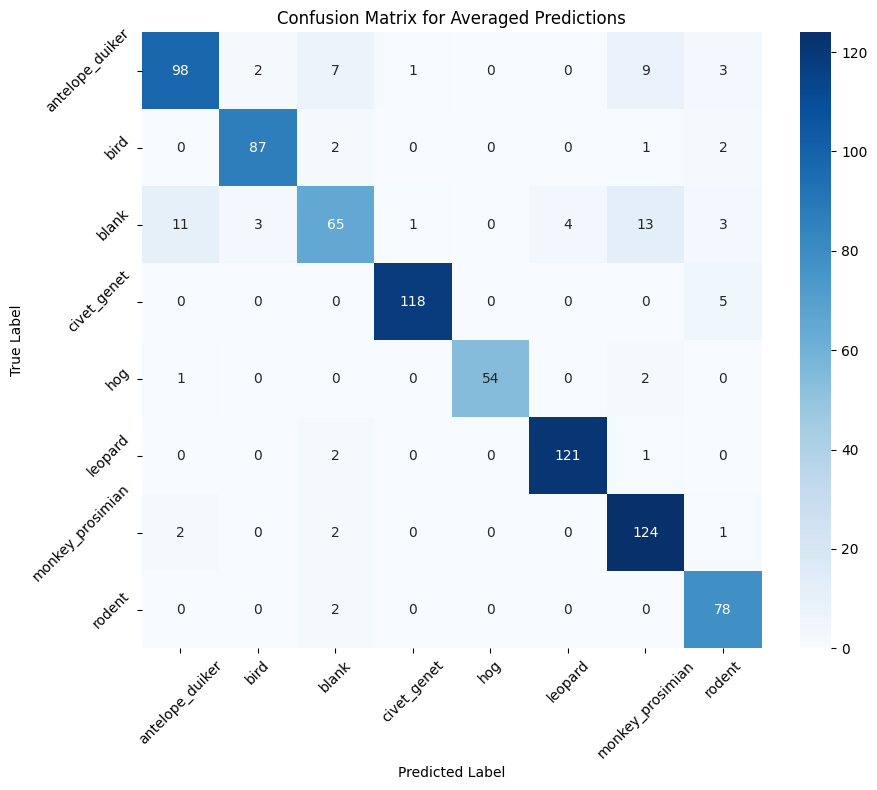

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicting on the validation set with both models
predictions_v2s = model_v2s.predict(val_generator_v2s)
predictions_b4 = model_b4.predict(val_generator_v2s)

# Averaging the predictions
average_predictions = (predictions_v2s + predictions_b4) / 2

# Converting probabilities to predicted class labels
predicted_classes_avg = np.argmax(average_predictions, axis=1)


true_classes = val_generator_v2s.classes

# Generating the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes_avg)

# Class names
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Averaged Predictions')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


# **Enseble Model( EfficientNet B4 L1L2 Regularization + EfficientNet V2s) Predictions**

Creating the final submission file

In [ ]:
import pandas as pd
from pathlib import Path

predictions_b4_l1l2 = base_path / 'model_b4_l1l2_Submission.csv'
predictions_v2s = base_path / 'model_v2s_predictions.csv'


df1 = pd.read_csv(predictions_b4_l1l2)
df2 = pd.read_csv(predictions_v2s)


if df1.shape != df2.shape or not all(df1['id'] == df2['id']):
    raise ValueError("CSV files have different structures or IDs do not match.")

# Calculate the average of the predictions
average_predictions = df1.copy()
for col in df1.columns[1:]:  # Skip the 'id' column
    average_predictions[col] = (df1[col] + df2[col]) / 2

# Save the averaged predictions to a new CSV file
output_file = base_path / 'final_model_b4_l1l2_v2s.csv'
average_predictions.to_csv(output_file, index=False)

print(f"Averaged predictions saved to {output_file}")


Averaged predictions saved to /content/drive/MyDrive/MachineLearning/final_model_b4_l1l2_v2s.csv
